# Exploratory Data Analysis

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce

In [5]:
df = pd.read_csv("nyc_taxi_data.csv.gz",nrows=10000000,compression="gzip")
#Cleaning data
df.dropna(axis=0,how="any",inplace=True)
passengerZero = df[df["passenger_count"] == 0].index
df.drop(passengerZero,inplace=True)
tripDistanceZero = df[df["trip_distance"] == 0].index
df.drop(tripDistanceZero,inplace=True)
incorrectRateCode = df[~df["rate_code"].isin([1,2,3,4,5,6])].index
df.drop(incorrectRateCode,inplace=True)
# add pickup hours columns to represent the datetime data rows
pickupHours = df["pickup_datetime"].str[11:13].astype("int64")
pickupHoursDf = pd.DataFrame({"pickupHours":pickupHours})
df = pd.concat([df,pickupHoursDf],axis=1)

In [15]:
# Only 1 vendor id
df["vendor_id"].unique()

array(['CMT'], dtype=object)

<Axes: xlabel='pickupHours', ylabel='tip_amount'>

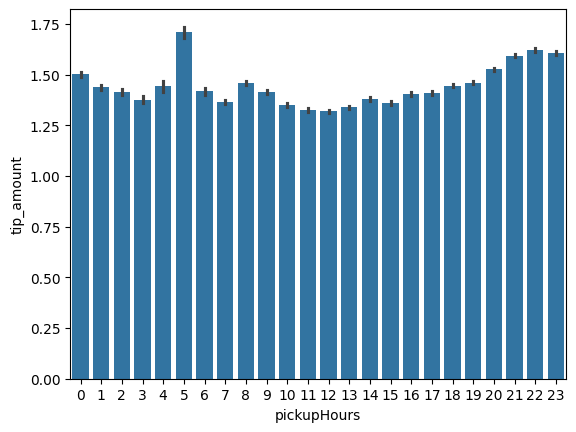

In [16]:
#Visualization
df.sort_values("pickupHours",inplace=True)
sns.barplot(x=df['pickupHours'],y=df['tip_amount'])


<Axes: xlabel='passenger_count', ylabel='tip_amount'>

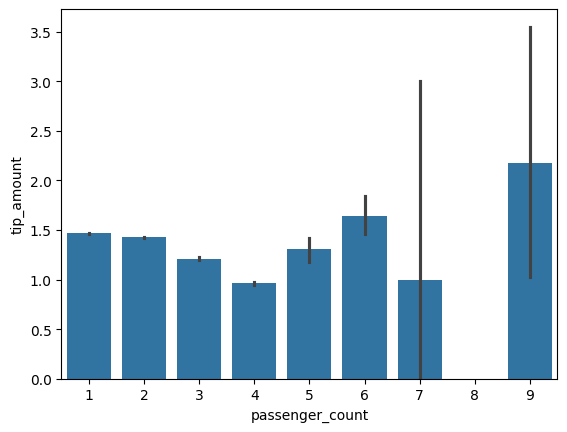

In [5]:
sns.barplot(x='passenger_count',y='tip_amount',data=df)

<Axes: xlabel='trip_distance', ylabel='tip_amount'>

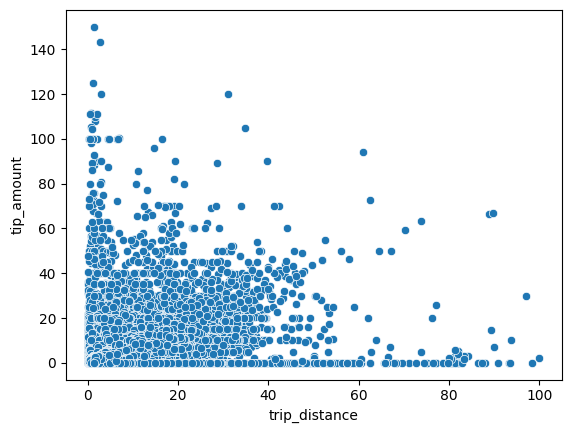

In [6]:
sns.scatterplot(x='trip_distance',y='tip_amount',data=df)

<Axes: xlabel='rate_code', ylabel='tip_amount'>

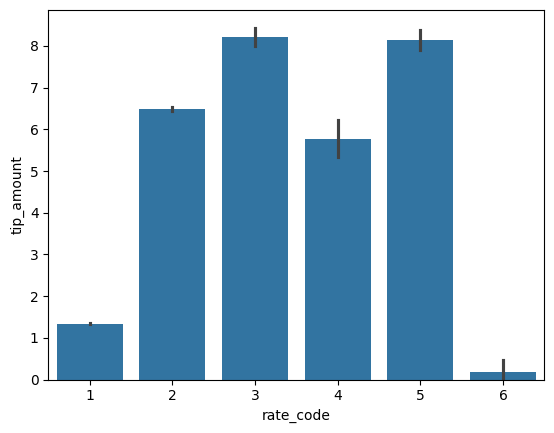

In [17]:
# The final rate code in effect at the end of the trip. 
# 1= Standard rate 2=JFK 3=Newark 4=Nassau or Westchester 5=Negotiated fare 6=Group ride# 
sns.barplot(x='rate_code',y='tip_amount',data=df)

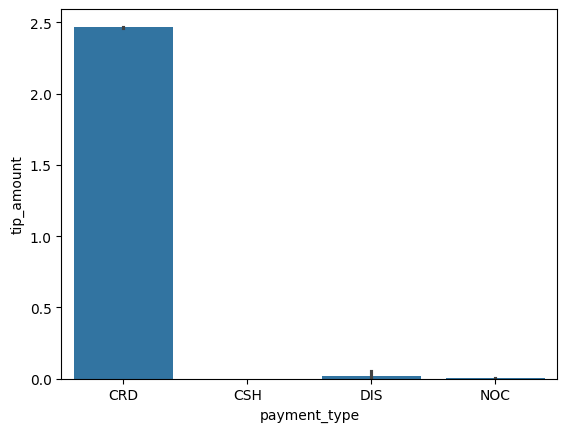

In [18]:
b = sns.barplot(x='payment_type',y='tip_amount',data=df)

In [26]:
# a lot of tips from paying with cash were not recorded
listval=(df[(df["payment_type"] == "CSH") & (df["tip_amount"]>0)]).index.tolist()
print(df.loc[listval].shape)
print(df[df["payment_type"]=="CSH"].shape)

(185, 19)
(1731524, 19)


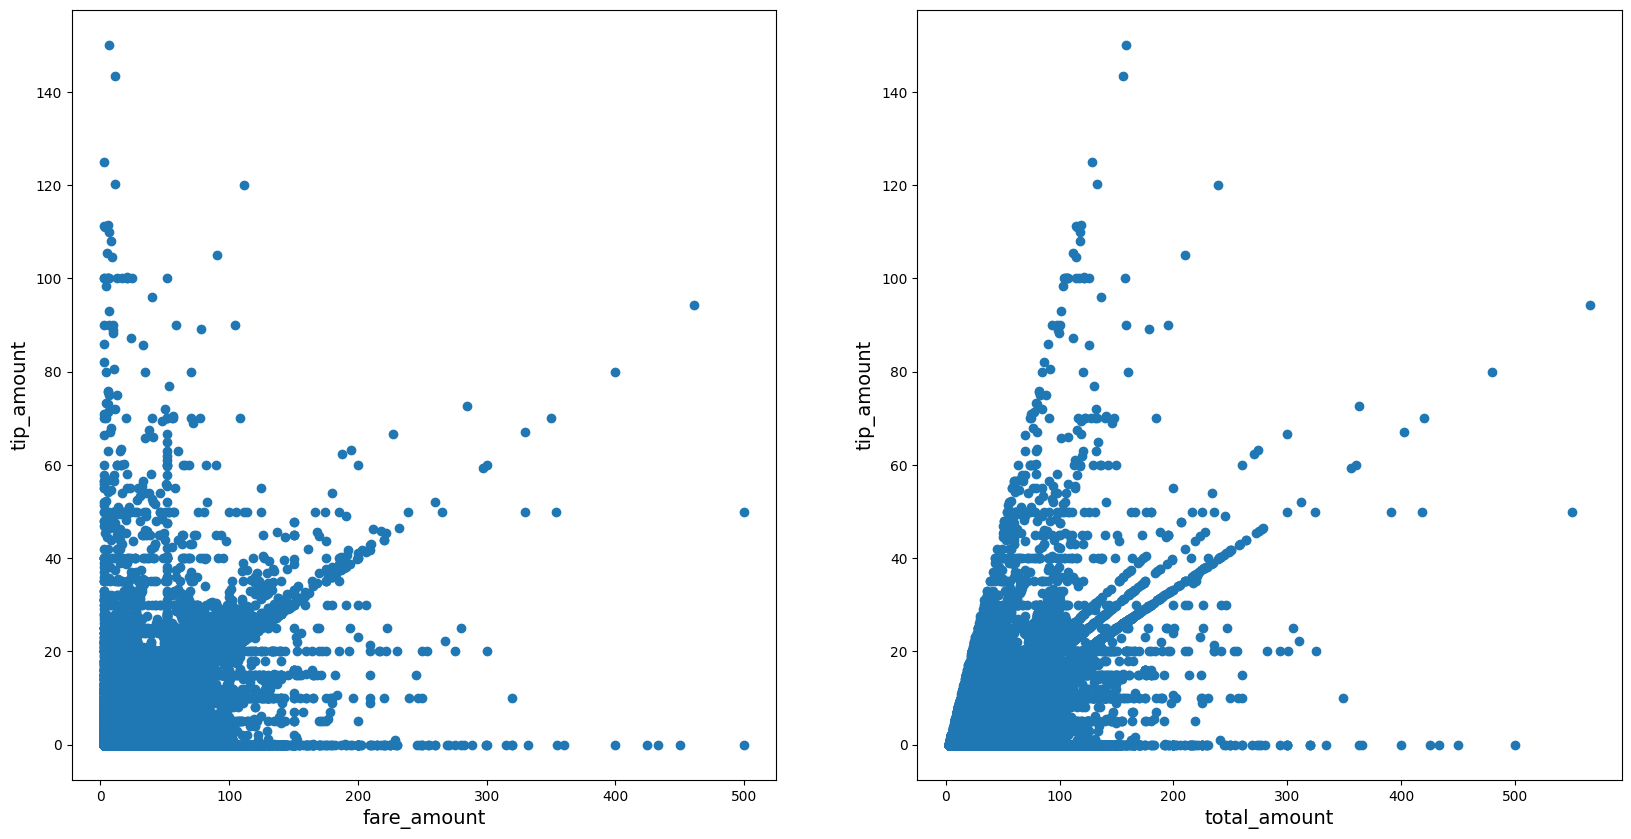

In [19]:
num_cols=['fare_amount','total_amount']
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,10))
count=0
for col in ax:
    if(count<len(num_cols)):
      col.set_xlabel(num_cols[count], fontsize=14)
      col.set_ylabel("tip_amount", fontsize=14)
      col.plot(df[num_cols[count]], df["tip_amount"],"o")
    count+=1
plt.show()

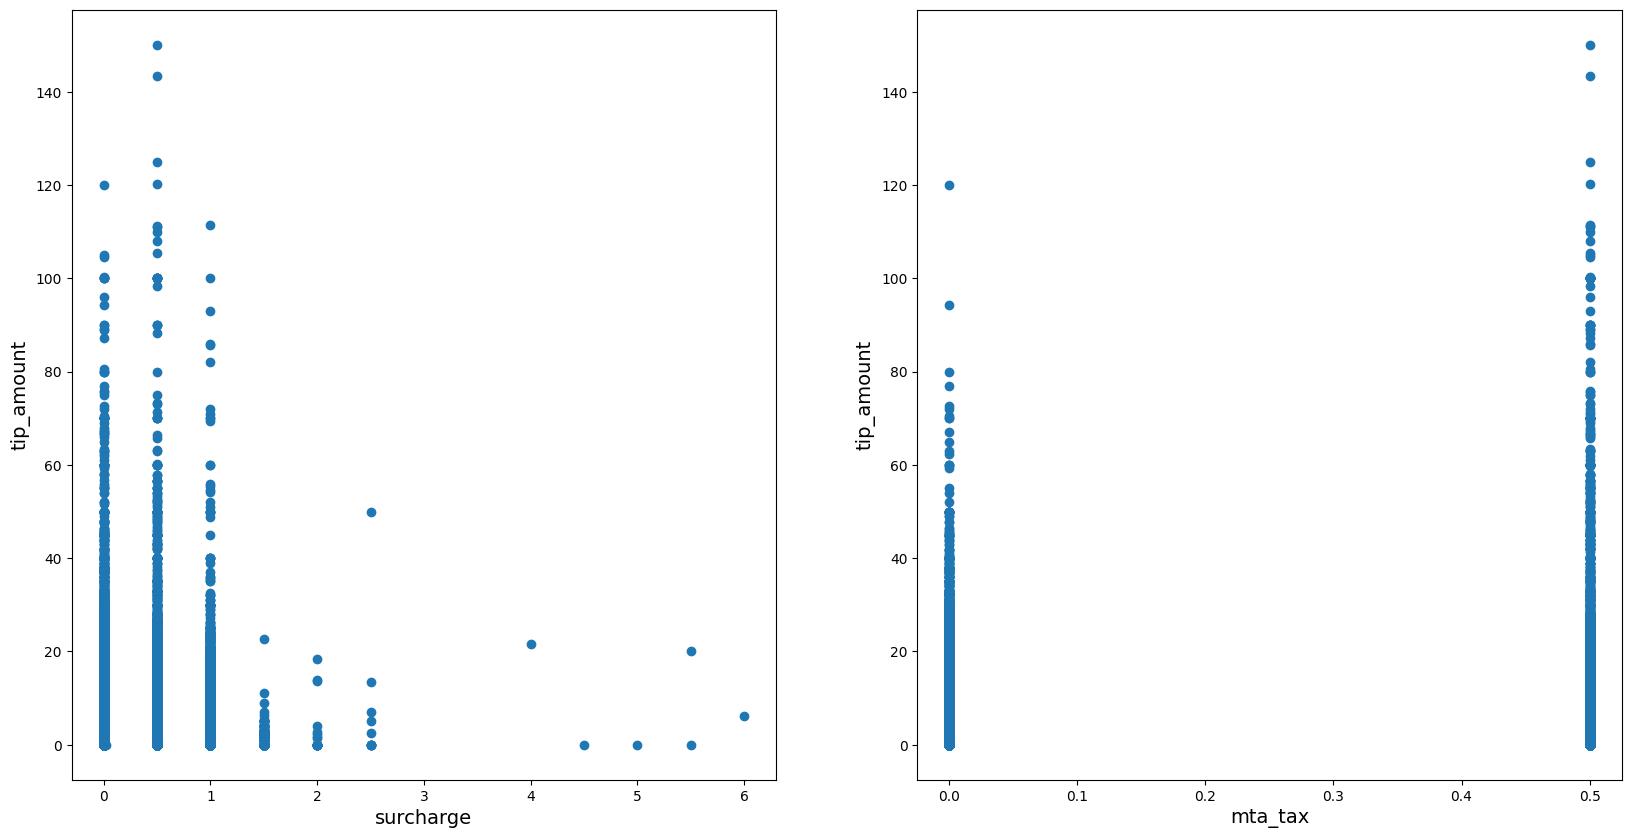

mta_tax
0.5    4201969
0.0      12196
Name: count, dtype: int64

In [30]:
num_cols=['surcharge','mta_tax']
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,10))
count=0
for col in ax:
    if(count<len(num_cols)):
      col.set_xlabel(num_cols[count], fontsize=14)
      col.set_ylabel("tip_amount", fontsize=14)
      col.plot(df[num_cols[count]], df["tip_amount"],"o")
    count+=1
plt.show()
df["mta_tax"].value_counts()

<Axes: xlabel='tolls_amount', ylabel='tip_amount'>

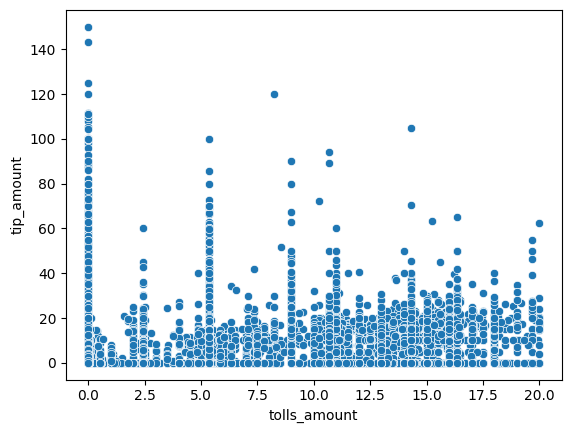

In [ ]:
#people are more likely to use card if the total cost is higher and tolls increase total cost
sns.scatterplot(x='tolls_amount',y='tip_amount',data=df)

<Axes: >

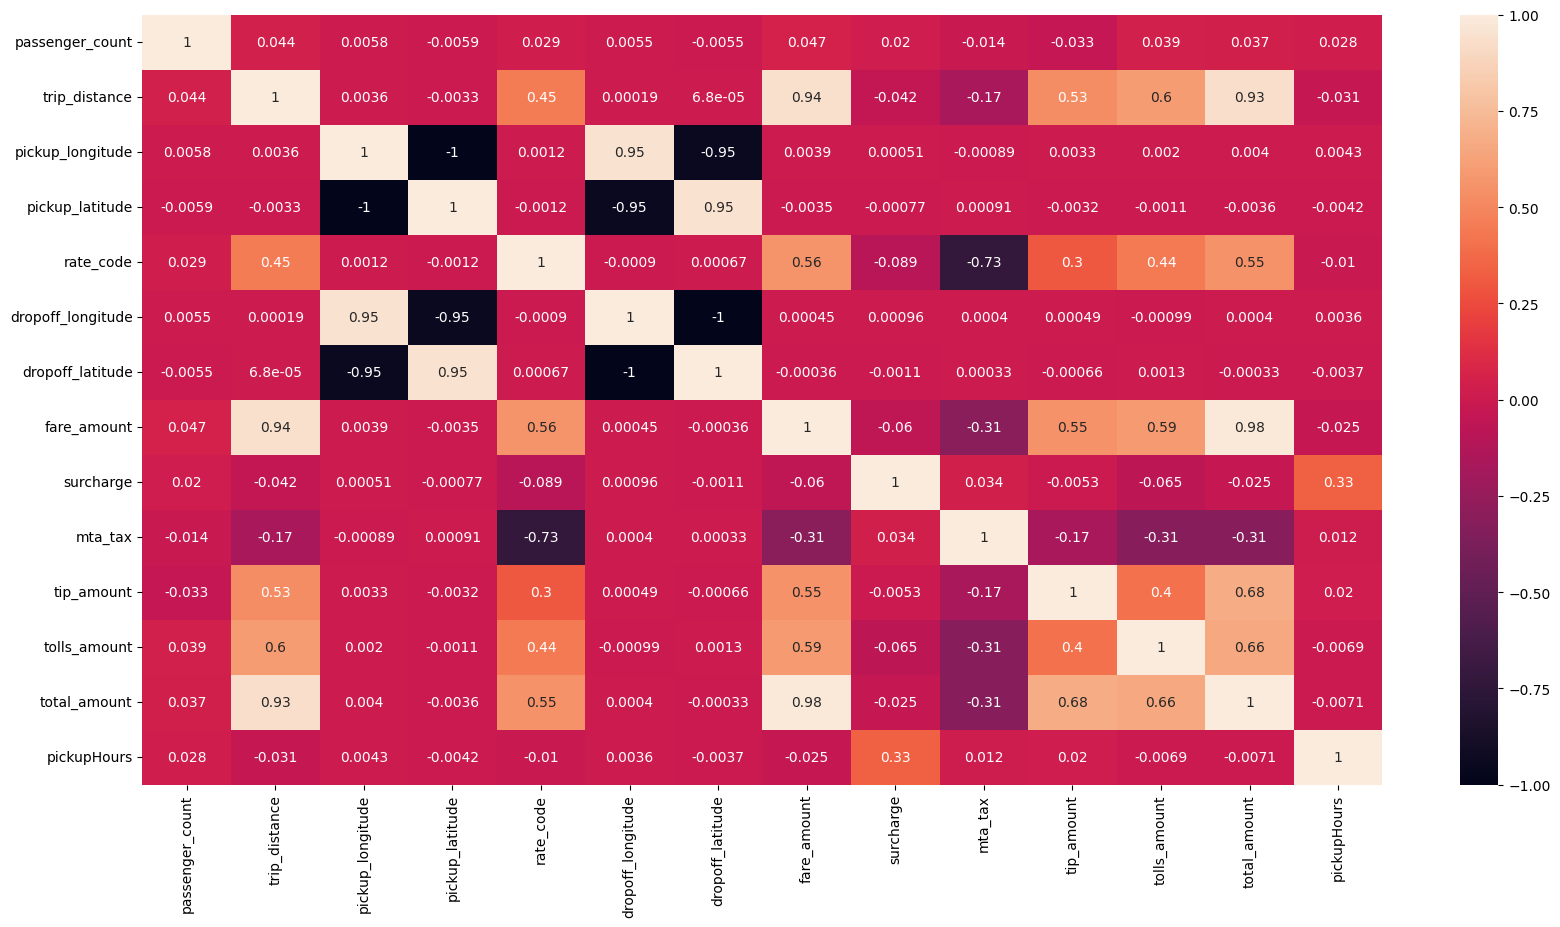

In [21]:
#encoding categorical variables to see possible correlations
df1 = df.select_dtypes(include=np.number)
df1c = df1.corr()
plt.figure(figsize=(20,10))
sns.heatmap(df1c, vmin = -1, vmax = 1, annot=True)

# Model training

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

x=df[['payment_type','fare_amount','trip_distance','rate_code']]
y=df['total_amount']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=.2,random_state=6)
pipe = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                 ('encoder', OneHotEncoder(handle_unknown="ignore")),
                 ('model', LinearRegression())])
pipe.fit(x_train,y_train)




Pipeline(steps=[('imputer',
                 SimpleImputer(fill_value='missing', strategy='constant')),
                ('encoder', OneHotEncoder(handle_unknown='ignore')),
                ('model', LinearRegression())])

In [7]:
y_train_pred = pipe.predict(x_train)
y_test_pred = pipe.predict(x_test)

# Evaluation

In [9]:
from sklearn.metrics import r2_score, mean_squared_error
print(r2_score(y_test, y_test_pred))
mean_squared_error(y_test, y_test_pred)

0.9737121855572719


3.461968663537594